# Planetesimal Formation
Pluto Jiang 2024

## Imports

In [ ]:
import os 
import sys

sys.path.append(os.path.abspath(os.path.join('..')) + '/DiscEvolution')

import numpy as np
import matplotlib.pyplot as plt

from DiscEvolution.constants import *
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.eos import IrradiatedEOS, LocallyIsothermalEOS, SimpleDiscEOS
from DiscEvolution.disc import *
from DiscEvolution.viscous_evolution import ViscousEvolution, ViscousEvolutionFV, LBP_Solution
from DiscEvolution.disc import AccretionDisc
from DiscEvolution.dust import *
from DiscEvolution.planet_formation import *

ModuleNotFoundError: No module named 'DiscEvolution'

## Planetesimal Formation Simulation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
start_time = time.time()
plt.rcParams.update({'font.size': 16})

def LBP_model(**kwargs):
    init_params = {"alpha":1e-3, "rmin":0.05, "rmax":1000, "nr":1000, "Mdot":1e-8, "fixed": False}
    init_params.update(kwargs)

    alpha = init_params['alpha']

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar()

    Mdot  = init_params["Mdot"]
    Rd    = 30
    R = grid.Rc
    Mdot *= (Msun / yr) / AU**2
    Sigma = (Mdot / (0.1 * alpha * R**2 * star.Omega_k(R))) * np.exp(-R/Rd)

    eos = SimpleDiscEOS(star, alpha)    
    eos.set_grid(grid)
    eos.update(0, Sigma)
    for i in range(100):
        Sigma = 0.5 * (Sigma + (Mdot / (3 * np.pi * eos.nu)) * np.exp(-R/Rd))
        eos.update(0, Sigma)

    gas = ViscousEvolutionFV()

    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma)

    if init_params['fixed'] == True:
        disc = FixedSizeDust(grid, star, eos, 0.01, 1, Sigma)
    v_visc = gas.viscous_velocity(disc, Sigma)
    Mdot = disc.Mdot(v_visc)[0]
    Mtot = disc.Mtot()/Msun

    return disc, grid, eos, gas, Mdot, Mtot




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
start_time = time.time()
plt.rcParams.update({'font.size': 16})

def LBP_model(**kwargs):
    init_params = {"alpha":1e-3, "rmin":0.05, "rmax":1000, "nr":1000, "Mdot":1e-8, "fixed": False}
    init_params.update(kwargs)

    alpha = init_params['alpha']

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar()

    Mdot  = init_params["Mdot"]
    Rd    = 30
    R = grid.Rc
    Mdot *= (Msun / yr) / AU**2
    Sigma = (Mdot / (0.1 * alpha * R**2 * star.Omega_k(R))) * np.exp(-R/Rd)

    eos = SimpleDiscEOS(star, alpha)    
    eos.set_grid(grid)
    eos.update(0, Sigma)
    for i in range(100):
        Sigma = 0.5 * (Sigma + (Mdot / (3 * np.pi * eos.nu)) * np.exp(-R/Rd))
        eos.update(0, Sigma)

    gas = ViscousEvolutionFV()

    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma)

    if init_params['fixed'] == True:
        disc = FixedSizeDust(grid, star, eos, 0.01, 1, Sigma)
    v_visc = gas.viscous_velocity(disc, Sigma)
    Mdot = disc.Mdot(v_visc)[0]
    Mtot = disc.Mtot()/Msun

    return disc, grid, eos, gas, Mdot, Mtot

def run_model(config):
    """
    Run the disk evolution model and plot the results.
    
    Parameters:
    config (dict): Configuration dictionary containing all parameters.
    """
    # Extract parameters from config
    grid_params = config['grid']
    sim_params = config['simulation']
    disc_params = config['disc']
    eos_params = config['eos']
    transport_params = config['transport']
    dust_growth_params = config['dust_growth']
    planetesimal_params = config['planetesimal']
    planet_params = config['planet']
    
    # Set up disc using LBP model
    disc, grid, eos, gas, Mdot, Mtot = LBP_model(alpha=disc_params['alpha'], rmin=grid_params['rmin'], rmax=grid_params['rmax'], nr=grid_params['nr'], Mdot=disc_params['M'], fixed=False)
    
    # Create time array
    if sim_params['t_interval'] == "power":
        # Determine the number of points needed
        if sim_params['t_initial'] == 0:
            num_points = int(np.log10(sim_params['t_final'])) + 1
            times = np.logspace(0, np.log10(sim_params['t_final']), num=num_points) * 2 * np.pi
        else:
            num_points = int(np.log10(sim_params['t_final'] / sim_params['t_initial'])) + 1
            times = np.logspace(np.log10(sim_params['t_initial']), np.log10(sim_params['t_final']), num=num_points) * 2 * np.pi
    elif type(sim_params['t_interval']) == list:
        times = np.array(sim_params['t_interval']) * 2 * np.pi * 1e6
    else:
        times = np.arange(sim_params['t_initial'], sim_params['t_final'], sim_params['t_interval']) * 2 * np.pi
    
    # Set up dynamics
    # ========================
    if transport_params['gas_transport']:
        gas = ViscousEvolutionFV()
    if transport_params['radial_drift'] and disc_params['d2g'] > 0:
        dust = SingleFluidDrift(settling=dust_growth_params['settling'], planetesimal=planetesimal_params['include_planetesimals'])
    
    if planetesimal_params['include_planetesimals']:
        disc._planetesimal = True
        planetesimal = PlanetesimalFormation(disc, d_planetesimal=planetesimal_params['diameter'], St_min=planetesimal_params['St_min'], 
                                             St_max=planetesimal_params['St_max'], pla_eff=planetesimal_params['pla_eff'])
        # Initialize a list to store non-zero M_peb values and corresponding times
        non_zero_M_peb = []
    

    # Set up planet(s)
    # ========================
    if planet_params['include_planets']:
        planet_model = Bitsch2015Model(disc, pb_gas_f=0.1)

        planets = Planets(Nchem = 0)
        
        Rp = planet_params['Rp']
        Mp = planet_params['Mp']

        for i in range(len(Rp)):
            planets.add_planet(0, Rp[i], Mp[i], 0)

    # Run model
    # ========================
    t = 0
    n = 0
    
    # Prepare plots
    if planetesimal_params['include_planetesimals']:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        axes[3].plot(grid.Rc, 0*grid.Rc, linestyle='dotted', color='black', label="Small dust")
        axes[3].plot(grid.Rc, 0*grid.Rc, linestyle="dashed", color='black', label="Large dust")
    elif transport_params['radial_drift']:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, axes = plt.subplots(figsize=(6, 6))
    
    # Set up initial plot lines
    try:
        axes[0].plot(grid.Rc, 0*grid.Rc, '-', color='black', label="Gas")
        axes[0].plot(grid.Rc, 0*grid.Rc, linestyle="dashed", color='black', label="Dust")
        #axes[0].plot(grid.Rc, 0*grid.Rc, linestyle="dotted", color='black', label="Small dust")
        #axes[0].plot(grid.Rc, 0*grid.Rc, linestyle="dashed", color='black', label="Large dust")
    except:
        pass
    
    # Figure for planet growth track and planetesimal capture radius
    if planet_params['include_planets']:
        fig2, axes2 = plt.subplots(3, 1, figsize=(10, 10))
        Rs, Mcs, Mes, = [], [], []

    time_steps = []

    for ti in times:
        while t < ti:
            time_steps.append(t)

            if transport_params['gas_transport']:
                dt = gas.max_timestep(disc)
            if transport_params['radial_drift']:
                v_visc = gas.viscous_velocity(disc)
                dt = min(dt,dust.max_timestep(disc, v_visc))
            dt = min(dt, ti - t)
            
            # Do dust evolution
            if transport_params['radial_drift']:
                dust(dt, disc, v_visc=v_visc)
            
            # Do advection-diffusion update
            try:
                dust_frac = disc.dust_frac
            except AttributeError:
                dust_frac = None
            
            if transport_params['gas_transport']:
                gas(dt, disc, [dust_frac])
            
            # Pin the values to >= 0 and <=1:
            disc.Sigma[:] = np.maximum(disc.Sigma, 0)        
            try:
                disc.dust_frac[:] = np.maximum(disc.dust_frac, 0)
                disc.dust_frac[:] /= np.maximum(disc.dust_frac.sum(0), 1.0)
            except AttributeError:
                pass
            
            # Update planetesimal surface density
            if planetesimal_params['include_planetesimals']:
                planetesimal.update(dt, disc, dust)
                
            if planetesimal_params['include_planetesimals'] and np.sum(disc.M_peb) > 0:
                non_zero_M_peb.append((t, disc.M_peb.copy()))

            # Do grain growth
            disc.update(dt)
            
            # Update planet growth
            if planet_params['include_planets']:
                planet_model.set_disc(disc)
                planet_model.update() # Update internal quantities after the disc has evolved
                planet_model.integrate(dt, planets) # Update the planet masses and radii

                # Collect data for planet growth track and capture radius
                for planet in planets:
                    Rs.append(planets.R.copy())
                    Mcs.append(planets.M_core.copy())
                    Mes.append(planets.M_env.copy())
                    if disc._planetesimal:
                        pass 

            t += dt
            n += 1

            if (n % 1000) == 0:
                print('Nstep: {}'.format(n))
                print('Time: {} yr'.format(t / (2 * np.pi)))
                print('dt: {} yr'.format(dt / (2 * np.pi)))
        
        if gas:
            try:
                l, = axes[0].loglog(grid.Rc, disc.Sigma_G / (AU*AU), label='t = {} Myr'.format(np.round(t / (2 * np.pi * 1e6), 2)))
                axes[0].set_xlabel('$R\\,[\\mathrm{au}]$')
                axes[0].set_ylabel('$\\Sigma_{\\mathrm{Gas}} [g/cm^2]$')
                axes[0].set_ylim(ymin=1e-6)
                axes[0].set_title('Gas Surface Density')
                axes[0].legend()
            except:
                axes.loglog(grid.Rc, disc.Sigma_G / (AU*AU), label='t = {} yrs'.format(np.round(t / (2 * np.pi))))
                axes.set_xlabel('$R\\,[\\mathrm{au}]$')
                axes.set_ylabel('$\\Sigma_{\\mathrm{Gas}} [g/cm^2]$')
                #axes.set_ylim(ymin=1e-6, ymax=1e6)
                axes.set_title('Gas Surface Density')
                axes.legend()

        if transport_params['radial_drift']:
            #axes[1].loglog(grid.Rc, disc.Sigma_D[0] / (AU*AU), linestyle="dotted", color=l.get_color())
            #axes[1].loglog(grid.Rc, disc.Sigma_D[1] / (AU*AU), linestyle='dashed', color=l.get_color())
            axes[1].loglog(grid.Rc, (disc.Sigma_D[0]+disc.Sigma_D[1]) / (AU*AU), linestyle="dashed", color=l.get_color())

            axes[1].set_xlabel('$R\\,[\\mathrm{au}]$')
            axes[1].set_ylabel('$\\Sigma_{\\mathrm{Dust}} [g/cm^2]$')
            #axes[1].set_ylim(ymin=1e-6, ymax=1e6)
            axes[1].set_title('Dust Surface Density')
            axes[1].set_ylim(ymin=1e-6)
        
        if planetesimal_params['include_planetesimals']:
            axes[2].loglog(grid.Rc, disc.Sigma_D[2] / (AU*AU), '-', color=l.get_color())
            axes[2].set_xlabel('$R\\,[\\mathrm{au}]$')
            axes[2].set_ylabel('$\\Sigma_{\\mathrm{Planetesimal}} [g/cm^2]$')
            axes[2].set_title('Planetesimal Surface Density')
            axes[2].set_ylim(ymin=1e-10, ymax=1e6)
            
            axes[3].loglog(grid.Rc, np.abs(disc.v_drift[0]), linestyle="dotted", color=l.get_color())
            axes[3].loglog(grid.Rc, np.abs(disc.v_drift[1]), linestyle='dashed', color=l.get_color())
            axes[3].set_xlabel('$R\\,[\\mathrm{au}]$')
            axes[3].set_ylabel('|Drift Velocity| [AU/yr]')
            axes[3].set_title('Pebble Flux')
            #axes[3].set_ylim(ymin=1e-15, ymax=1e-5)
        elif transport_params['radial_drift']:
            axes[2].plot(grid.Rc, 0*grid.Rc, label='t = {} Myr'.format(np.round(t / (2 * np.pi * 1e6), 2)), color=l.get_color())
            axes[2].loglog(grid.Rc, disc.v_drift[0], linestyle="dotted", color=l.get_color())
            axes[2].loglog(grid.Rc, disc.v_drift[1], linestyle='dashed', color=l.get_color())

            axes[2].set_xlabel('$R\\,[\\mathrm{au}]$')
            axes[2].set_ylabel('Drift Velocity')
            axes[2].set_ylim(ymin=1e-6)
            axes[2].set_title('Drift Velocity')
            axes[2].legend()

    
    if planet_params['include_planets']:
        # Plot planet growth track
        Rs, Mcs, Mes = [ np.array(X) for X in [Rs, Mcs, Mes]]

        axes2[0].loglog(time_steps, Mcs)
        axes2[0].set_xlabel('Time [Myr]')
        axes2[0].set_ylabel('$M_\\mathrm{core},[M_\\oplus]$')
        axes2[0].set_title('Core Mass vs Time')
        axes2[0].legend()

        axes2[1].loglog(time_steps, Mes/317.8)
        axes2[1].set_xlabel('Time [Myr]')
        axes2[1].set_ylabel('$M_\\mathrm{env},[M_J]$')
        axes2[1].set_title('Envelope Mass vs Time')

        axes2[2].loglog(time_steps, Rs)
        axes2[2].set_xlabel('Time [Myr]')
        axes2[2].set_ylabel('$R,[R_J]$')
        axes2[2].set_title('Radius vs Time')

        # Plot planetesimal capture radius
        if disc._planetesimal:
            t, R_capt = zip(*planet_capture_radius)
            axes2[1].plot(t, R_capt, 'o-')
            axes2[1].set_xlabel('Time [Myr]')
            axes2[1].set_ylabel('Capture Radius [cm]')
            axes2[1].set_title('Planetesimal Capture Radius')

    plt.tight_layout()
    plt.show()

# Example usage:
# With planetesimals
#run_model(config)
#print("--- %s seconds ---" % (time.time() - start_time))
# Without planetesimals
# config['planetesimal']['include_planetesimals'] = False
# run_model(config)

# # Without planetesimals and dust
# config['planetesimal']['include_planetesimals'] = False
# config['disc']['d2g'] = 0
# config['transport']['radial_drift'] = False
# run_model(config)

## Lenz No Planet Accretion

In [ ]:
config_Lenz = {
    "grid": {
        "rmin": 0.1,
        "rmax": 1000,
        "nr": 1000,
        "spacing": "natural",
        "Mdot": 1e-8,
        "fixed": False
    },
    "simulation": {
        "t_initial": 0,
        "t_final": 1e6,
        "t_interval": [0, 0.1, 0.5, 1, 2], # Myr
    },
    "disc": {
        "alpha": 1e-3,
        "M": 0.05,
        "Rc": 35.0,
        "d2g": 0.01
    },
    "eos": {
        "type": "Isothermal",
        "h0": 1/30,
        "q": -0.25
    },
    "transport": {
        "gas_transport": True,
        "radial_drift": True
    },
    "dust_growth": {
        "feedback": False,
        "settling": False,
        "f_ice": 1,           # Set ice fraction to 0
        "uf_0": 1000,          # Fragmentation velocity for ice-free grains (cm/s)
        "uf_ice": 1000,        # Set same as uf_0 to ignore ice effects
        "thresh": 0.1        # Set high threshold to prevent ice effects
    },
    "planetesimal": {
        "include_planetesimals": False,
        "diameter": 100,  # km
        "St_min": 0.01,
        "St_max": 10,
        "pla_eff": 0.1
    },
    "planet": {
        "include_planets": False,
        "Rp": [3],    # initial position of embryo [AU]
        "Mp": [1]     # initial mass of embryo [M_Earth]
    }
}

run_model(config_Lenz)

NameError: name 'run_model' is not defined

## Lenz Planet Accretion

c:\Users\Queena\Documents\DiscEvolution/DiscEvolution\eos.py:210: RuntimeWarning: divide by zero encountered in divide
  return 1. / Pr_1
C:\Users\Queena\AppData\Local\Temp\ipykernel_4276\2765356953.py:201: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  l, = axes[0].loglog(grid.Rc, disc.Sigma_G / (AU*AU), label='t = {} Myr'.format(np.round(t / (2 * np.pi * 1e6), 2)))
C:\Users\Queena\AppData\Local\Temp\ipykernel_4276\2765356953.py:241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[2].loglog(grid.Rc, disc.v_drift[0], linestyle="dotted", color=l.get_color())
C:\Users\Queena\AppData\Local\Temp\ipykernel_4276\2765356953.py:246: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[2].set_ylim(ymin=1e-6)
c:\Users\Queena\Documents\DiscEvolution/DiscEvolution\planet_formation.py:169: RuntimeWarning: divide by zero encountered in divide
  Mdot_PY = self._fPiso * T81**-0.5 * M_core**(11/3.) / M

Nstep: 1000
Time: 0.005749503461904676 yr
dt: 5.7503993565828305e-06 yr
Nstep: 2000
Time: 0.01150053988247923 yr
dt: 5.751617383036832e-06 yr
Nstep: 3000
Time: 0.017252666762926354 yr
dt: 5.752610028950862e-06 yr
Nstep: 4000
Time: 0.023005721681491825 yr
dt: 5.753483442979365e-06 yr
Nstep: 5000
Time: 0.028759608796335243 yr
dt: 5.75427920967576e-06 yr
Nstep: 6000
Time: 0.0345142622575307 yr
dt: 5.755018877895533e-06 yr
Nstep: 7000
Time: 0.040269632925928105 yr
dt: 5.755715373503109e-06 yr
Nstep: 8000
Time: 0.04602568215328028 yr
dt: 5.7563771963291175e-06 yr
Nstep: 9000
Time: 0.05178237841090461 yr
dt: 5.757010302502911e-06 yr
Nstep: 10000
Time: 0.057539695276114355 yr
dt: 5.757619065333488e-06 yr
Nstep: 11000
Time: 0.06329761014269872 yr
dt: 5.758206813157401e-06 yr
Nstep: 12000
Time: 0.0690561033503134 yr
dt: 5.758776152010876e-06 yr
Nstep: 13000
Time: 0.0748151575718067 yr
dt: 5.759329170000472e-06 yr
Nstep: 14000
Time: 0.08057475736738705 yr
dt: 5.759867572523114e-06 yr
Nstep: 1500

KeyboardInterrupt: 

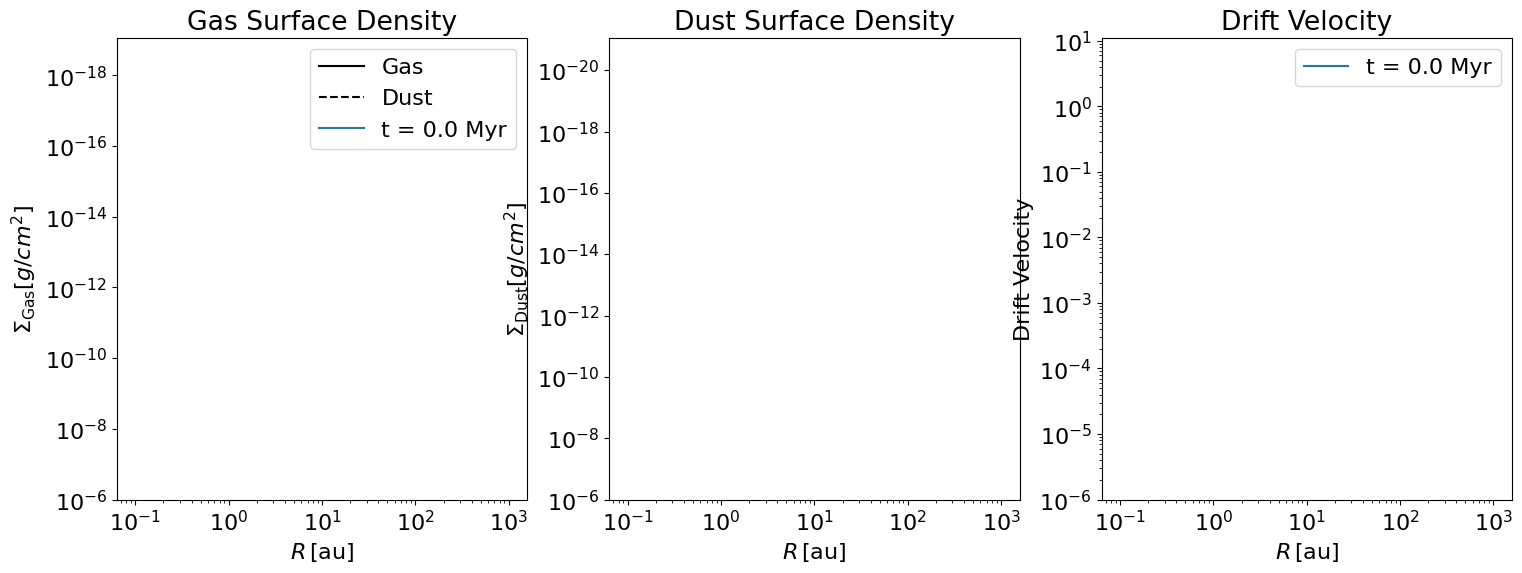

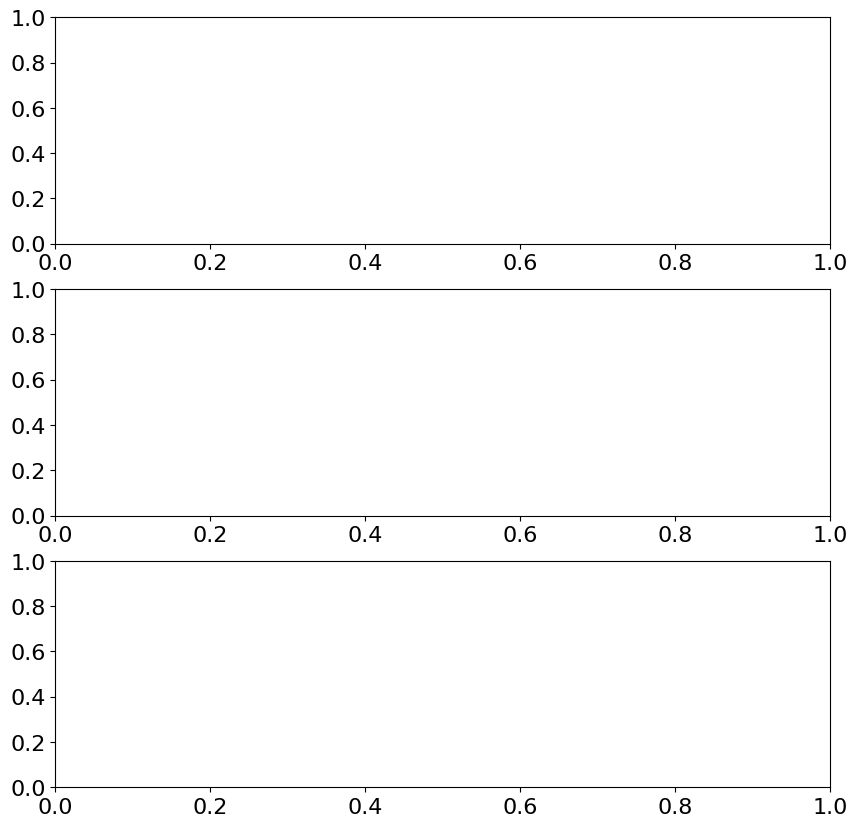

In [ ]:
config_Lenz = {
    "grid": {
        "rmin": 0.1,
        "rmax": 1000,
        "nr": 1000,
        "spacing": "natural"
    },
    "simulation": {
        "t_initial": 0,
        "t_final": 1e6,
        "t_interval": [0, 0.5], # Myr
    },
    "disc": {
        "alpha": 1e-3,
        "M": 0.05,
        "Rc": 35.0,
        "d2g": 0.01
    },
    "eos": {
        "type": "Isothermal",
        "h0": 1/30,
        "q": -0.25
    },
    "transport": {
        "gas_transport": True,
        "radial_drift": True
    },
    "dust_growth": {
        "feedback": False,
        "settling": False,
        "f_ice": 1,           # Set ice fraction to 0
        "uf_0": 1000,          # Fragmentation velocity for ice-free grains (cm/s)
        "uf_ice": 1000,        # Set same as uf_0 to ignore ice effects
        "thresh": 0.1        # Set high threshold to prevent ice effects
    },
    "planetesimal": {
        "include_planetesimals": False,
        "diameter": 100,  # km
        "St_min": 0.01,
        "St_max": 10,
        "pla_eff": 0.1
    },
    "planet": {
        "include_planets": True,
        "Rp": [1],    # initial position of embryo [AU]
        "Mp": [0.1]     # initial mass of embryo [M_Earth]
    }
}

# Dust might be too small and it is not growing
#run_model(config_Lenz)

In [ ]:
config_Danti = {
    "grid": {
        "rmin": 0.1,
        "rmax": 1000,
        "nr": 1000,
        "spacing": "natural"
    },
    "simulation": {
        "t_initial": 0,
        "t_final": 1e6,
        "t_interval": [0, 0.5, 1, 3], # Myr
    },
    "disc": {
        "alpha": 1e-3,
        "M": 0.128,
        "Rc": 137.0,
        "d2g": 0.01
    },
    "eos": {
        "type": "LocallyIsothermalEOS",
        "h0": 1/30,
        "q": -0.25
    },
    "transport": {
        "gas_transport": True,
        "radial_drift": True
    },
    "dust_growth": {
        "feedback": False,
        "settling": False,
        "f_ice": 1,           # Set ice fraction to 0
        "uf_0": 500,          # Fragmentation velocity for ice-free grains (cm/s)
        "uf_ice": 500,        # Set same as uf_0 to ignore ice effects
        "thresh": 0.1,        # Set high threshold to prevent ice effects
    },
    "planetesimal": {
        "include_planetesimals": True,
        "diameter": 1,  # km
        "St_min": 0.01,
        "St_max": None,
        "pla_eff": 0.1
    },
    "planet": {
        "include_planets": False,
        "Rp": [3],    # initial position of embryo [AU]
        "Mp": [1]     # initial mass of embryo [M_Earth]
    }
}

#run_model(config_Danti)